In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.python.framework import ops

import h5py


%matplotlib inline
np.random.seed(1)

## Preprocess MNIST dataset

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
def one_hot(matrix, depth=10):
    one_hot_matrix = np.zeros((matrix.size, matrix.max()+1))
    one_hot_matrix[np.arange(matrix.size),matrix] = 1
    return one_hot_matrix
    
def split_batches(X, Y, minibatch_size):
    minibatches = []
    for x in range(0, Y.shape[0], minibatch_size):
        minibatches.append((X[x:x+minibatch_size, :], Y[x:x+minibatch_size, :]))
    return minibatches

In [6]:
# convert pd dataframe to numpy array
X_data = train_data.values

# 42000 examples
# use 2000 for test and 40000 for training
# first col is the labels
X_train, X_test = X_data[:40000, 1:], X_data[40000:, 1:]
Y_train, Y_test = X_data[:40000, 0], X_data[40000:, 0] # reshaping the array to second numpy rank
Y_train_one_hot = one_hot(Y_train)
Y_test_one_hot = one_hot(Y_test)

print(X_train.shape, "X_train")
print(X_test.shape, "X_test")
print(Y_train_one_hot.shape, "X_train labels one hot")
print(Y_test_one_hot.shape, "X_test labels one hot")

X_train, X_test = X_train / 255, X_test / 255 # normalize data

(40000, 784) X_train
(2000, 784) X_test
(40000, 10) X_train labels one hot
(2000, 10) X_test labels one hot


1 label of the first example


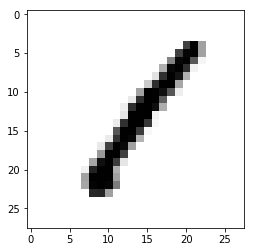

In [7]:
print(Y_train[0], "label of the first example")
plt.imshow(X_train[0, :].reshape(28,28), cmap=cm.binary)

## Build ANN model

Cost after epoch 0: 2.351977
Cost after epoch 100: 0.387087
Cost after epoch 200: 0.245216
Cost after epoch 300: 0.190131
Cost after epoch 400: 0.155205
Cost after epoch 500: 0.130600
Cost after epoch 600: 0.112093
Cost after epoch 700: 0.097521
Cost after epoch 800: 0.085648
Cost after epoch 900: 0.075675
Cost after epoch 1000: 0.067146
Cost after epoch 1100: 0.059753
Cost after epoch 1200: 0.053220
Cost after epoch 1300: 0.047387
Cost after epoch 1400: 0.042176


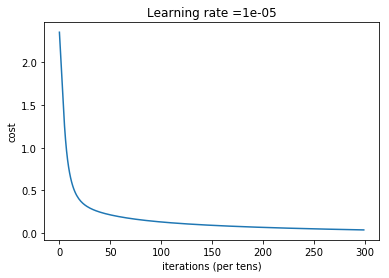

Parameters have been trained!
Train Accuracy: 0.0
Test Accuracy: 0.0


In [11]:
# Hyper parameters
minibatch_size =  1000 # 40000 examples for training: batch size = 2000 examples each => 40000 / 2000 = 40 batches
num_minibatches = 40000 / minibatch_size
costs = [] # save the cost after each iterations for later plotting
num_epochs = 1500 
learning_rate = 0.00001

ops.reset_default_graph()  # to be able to rerun the model without overwriting tf variables

X = tf.placeholder(tf.float32, shape=(None, 784))
Y = tf.placeholder(tf.float32, shape=(None, 10))

W1 = tf.get_variable("W1", [784,100], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b1 = tf.get_variable("b1", [1,100], initializer = tf.zeros_initializer())
W2 = tf.get_variable("W2", [100,50], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b2 = tf.get_variable("b2", [1, 50], initializer = tf.zeros_initializer())
W3 = tf.get_variable("W3", [50, 10], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b3 = tf.get_variable("b3", [1, 10], initializer = tf.zeros_initializer())


# Forward prop.
Z1 = tf.add(tf.matmul(X, W1), b1) 
A1 = tf.nn.relu(Z1)                                    
Z2 = tf.add(tf.matmul(A1, W2), b2)                     
A2 = tf.nn.relu(Z2)                                    
Z3 = tf.add(tf.matmul(A2, W3), b3)                     

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))

# Back prop.
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cost)

init = tf.global_variables_initializer()

# Split batches
minibatches = split_batches(X_train, Y_train_one_hot, minibatch_size=minibatch_size)


saver = tf.train.Saver()
with tf.Session() as sess:

    # Run the initialization
    sess.run(init)
    
    # Do the training loop
    for epoch in range(num_epochs):
        epoch_cost = 0. # Defines a cost related to an epoch
        
        for minibatch in minibatches:

            # Select a minibatch
            X_minibatch, Y_minibatch = minibatch

            _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X:X_minibatch, Y:Y_minibatch})

            epoch_cost += minibatch_cost / num_minibatches

        # Print the cost every epoch
        if epoch % 100 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if epoch % 5 == 0:
            costs.append(epoch_cost) # save the cost for plotting

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # save the parameters in a variable
    save_path = saver.save(sess, "./model.ckpt")
    print ("Parameters have been trained!")


In [19]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./model.ckpt")
    print("Model restored.")
    
    correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Z3,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(accuracy.eval(feed_dict={X: X_train, Y: Y_train_one_hot}), "Accuracy on train")
    print(accuracy.eval(feed_dict={X: X_test, Y: Y_test_one_hot}), "Accuracy on test")

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
0.9916 Accuracy on train
0.9635 Accuracy on test


## Kaggle project 

In [30]:
X_data_test = test_data.values

with tf.Session() as sess:
    saver.restore(sess, "./model.ckpt")
    print("Model restored.")
    prediction=tf.argmax(Z3,1)
    predicted_labels = sess.run(prediction, feed_dict={X: X_data_test})
    print(predicted_labels, 'predicted labels')

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
[2 0 9 ..., 3 9 2] predicted labels


the first 3 predictions are correct (check the predicted labels in the above cell)


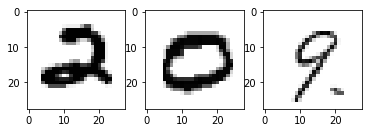

In [59]:
plt.subplot(1, 3, 1)
plt.imshow(X_data_test[0, :].reshape(28,28), cmap=cm.binary)
plt.subplot(1, 3, 2)
plt.imshow(X_data_test[1, :].reshape(28,28), cmap=cm.binary)
plt.subplot(1, 3, 3)
plt.imshow(X_data_test[2, :].reshape(28,28), cmap=cm.binary)
print("the first 3 predictions are correct (check the predicted labels in the above cell)")

In [67]:
# save the predictions in file to submit it for Kaggle
results = pd.DataFrame({'ImageId': pd.Series(range(1, len(predicted_labels) + 1)), 'Label': pd.Series(predicted_labels)})
results.to_csv('results.csv', index=False)